In [1]:
import numpy as np
from network import Network, flatten_NN, reconstruct_NN
from fc_layer import FCLayer
from activation_layer import ActivationLayer
from activation_function import tanh, soft_max
from typing import List, Tuple
from crossover import crossover
from mutation import mutate
from mate import mate
import pandas as pd
import matplotlib.pyplot as plt
from helper_module import split_train_set, split_train_test_sets
from numpy.typing import NDArray
from fitness import fitness, sharpe_ratio, sortino_ratio
from initialize_nn import initialize_nn
from functools import partial
from enum import Enum

C:\Users\pc\AppData\Local\Temp\ipykernel_16240\14204046.py:10: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


                Close       Open       High        Low   Volume
Date                                                           
1986-01-02   172.6575   172.6575   172.6575   172.6575    600.0
1986-01-03   172.6575   172.6575   172.6575   172.6575   1900.0
1986-01-06   175.4879   175.4879   175.4879   175.4879   2800.0
1986-01-07   181.1488   175.4879   181.1488   175.4879   3200.0
1986-01-09   181.1488   181.1488   181.1488   181.1488   2600.0
...               ...        ...        ...        ...      ...
2023-09-12  1781.0000  1786.0000  1809.0000  1781.0000  12985.0
2023-09-13  1787.0000  1799.0000  1799.0000  1781.0000  16850.0
2023-09-14  1795.0000  1795.0000  1795.0000  1782.0000  12070.0
2023-09-15  1752.0000  1795.0000  1810.0000  1752.0000  29105.0
2023-09-18  1752.0000  1789.0000  1789.0000  1752.0000  27225.0

[8861 rows x 5 columns]


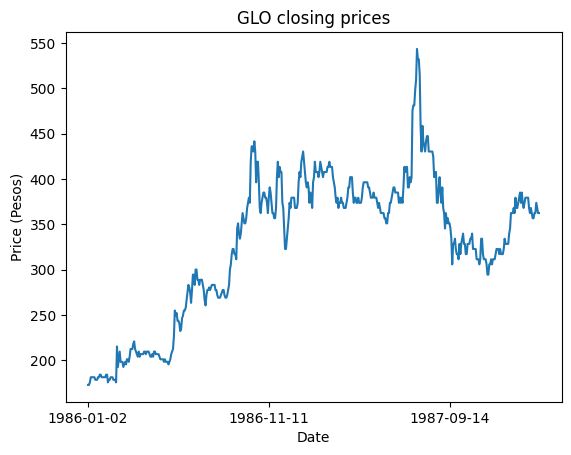

In [2]:
# read and print sample historical stock price data
series = pd.read_csv('../../Data/PH-historical-stock-price-data-csv/GLO.csv', header = 0, index_col = 'Date')
print(series)

# plot historical stock price data
fig, ax = plt.subplots()    
ax.set_title('GLO closing prices')
ax.set_xlabel('Date')
ax.set_ylabel('Price (Pesos)')
ax.plot(series['Close'].head(500))
ax.set_xticks(ax.get_xticks()[::200])
plt.show()

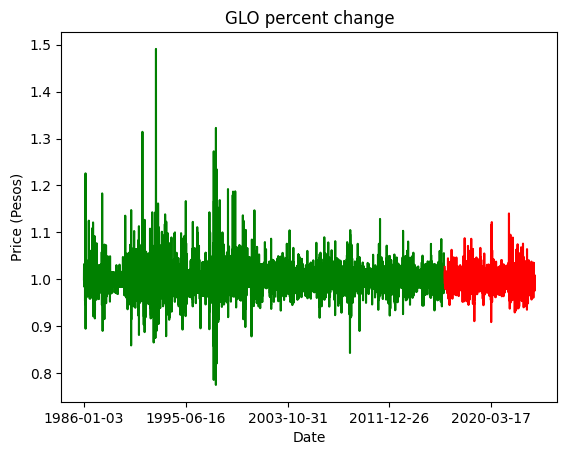

In [3]:
# use only the closing prices of the stock
series = series['Close']
series = series.pct_change(1) + 1
series = pd.Series(data = series, name = 'Close_pct_change')

# split data into train and test sets
train, test = split_train_test_sets(series)

# plot the train and test sets
fig, ax = plt.subplots()    
ax.set_title('GLO percent change')
ax.set_xlabel('Date')
ax.set_ylabel('Price (Pesos)')
ax.plot(train, 'g')
ax.plot(test, 'r')
ax.set_xticks(ax.get_xticks()[::2000])
plt.show()

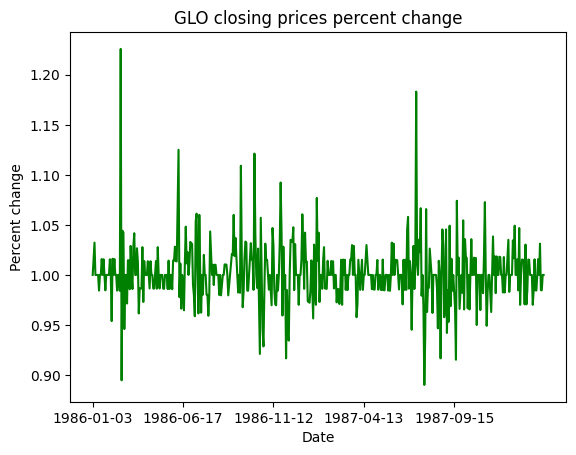

In [4]:
# split the train set into multiple batches
train_set = split_train_set(train)

# plot a sample of the train set
fig, ax = plt.subplots()    
ax.set_title('GLO closing prices percent change')
ax.set_xlabel('Date')
ax.set_ylabel('Percent change')
ax.plot(train_set[0], 'g')
ax.set_xticks(ax.get_xticks()[::100])
plt.show()

In [5]:
test_sample = train_set[0]
test_sample_cum_daily_returns = test_sample.cumprod() - 1
cum_return_entire_period = test_sample_cum_daily_returns.tail(1)
test_return = cum_return_entire_period * 100
print(test_return)


Date
1988-02-10    109.836005
Name: Close_pct_change, dtype: float64


In [6]:
# initialize neural network
net = initialize_nn()

# flatten neural network
test_flat_NN, test_num_layers, test_NN_layers_dims = flatten_NN(net)

# reconstruct neural network
test_reconstructed_NN = reconstruct_NN(flat_NN = test_flat_NN, 
                                       num_layers = test_num_layers, 
                                       NN_layer_dims = test_NN_layers_dims)

test_offspring1, test_offspring2 = mate(net, test_reconstructed_NN)

In [7]:
test_sample = np.zeros([1,150])
for i in range(150):
    test_sample[0][i] = np.random.uniform(-10,10)

print(net.predict(test_sample))
print(test_reconstructed_NN.predict(test_sample))
print(test_offspring1.predict(test_sample))
print(test_offspring2.predict(test_sample))
print(np.argmax(test_offspring1.predict(test_sample)))
print(np.argmax(test_offspring2.predict(test_sample)))

[array([[0.65328061, 0.00925355, 0.33746584]])]
[array([[0.65328061, 0.00925355, 0.33746584]])]
[array([[0.63223077, 0.00895539, 0.35881384]])]
[array([[0.68789956, 0.01405528, 0.29804516]])]
0
0


In [8]:
class trading_action(Enum):
    Buy = 0
    Hold = 1
    Sell = 2

In [9]:
def regime(features: NDArray, nn:Network):
    probabilities = nn.predict(features)
    index = np.argmax(probabilities)

    match index:
        case 0:
            return trading_action.Buy.value
        
        case 1:
            return trading_action.Hold.value
        
        case 2:
            return trading_action.Sell.value

        case _:
            pass

In [10]:
def fitness(window, train_set, nn: Network, regime):
    fitness = 0
    
    # get the strategy regime
    regime = partial(regime, nn = nn)
    regime_output = train_set.rolling(window=window).apply(regime, raw = True)
    regime_series = pd.Series(data = regime_output, name = 'Regime')


    series = pd.concat([train_set, regime_series], axis = 1)
    series['Returns'] = 1.
    has_long_position:bool = False
    num_trades:int = 0
    
    # loop through all the elements in the series
    for i in range(len(series)):
        match series['Regime'].iat[i]:
            case trading_action.Buy.value:
                has_long_position = True
                num_trades += 1
                series['Returns'].iat[i] = series['Close_pct_change'].iat[i]
            case trading_action.Sell.value:
                has_long_position = False
                series['Returns'].iat[i] = series['Close_pct_change'].iat[i]
            case trading_action.Hold.value:
                series['Returns'].iat[i] = 1
            case _:
                pass
        
        print(series['Returns'].iat[i], '\t', series['Regime'].iat[i], '\t', series['Close_pct_change'].iat[i])
            
    # get returns for buy and hold strategy
    # bnh_returns = series['Close_pct_change'].cumprod().iat[-1]
    bnh_returns = series['Close_pct_change'].cumprod() - 1
    bnh_returns = bnh_returns.iat[-1] * 100
    
    # get the returns of the strategy
    strat_returns = series['Returns'].cumprod() - 1 
    strat_returns = strat_returns.iat[-1] * 100

    # get the downside returns
    # and compute for the downside returns standard deviation
    downside_returns_series = series.loc[series['Returns'] < 1]
    downside_returns_std = downside_returns_series['Returns'].std()

    # compute for the sortino ration of the strategy
    strat_sortino_ratio = sortino_ratio(portfolio_returns = strat_returns, 
                                        std_downside_portfolio_returns = downside_returns_std)
    
    # compute for max drawdown
    max_drawdown = np.ptp(series["Returns"])/series["Returns"].max()

    # check if sortino ratio is negative or NaN;
    # if it is negative or NaN, degenerate it into 0
    # if np.isnan(strat_sortino_ratio) or num_trades > 20:
    #     strat_sortino_ratio = float('-inf')

    # if (strat_sortino_ratio == float('-inf')) and (max_drawdown == 0.):
    #     fitness = float("-inf")

    if strat_sortino_ratio > 0:
        # fitness = strat_sortino_ratio * (1/(1+num_trades)) * max_drawdown
        fitness = strat_sortino_ratio * (1-max_drawdown)
    
    elif strat_sortino_ratio < 0:
        # fitness = strat_sortino_ratio * (num_trades) * max_drawdown
        fitness = strat_sortino_ratio * max_drawdown
    
    # compute for the standard deviation of the strategy
    # return_std = stock.df['returns'].std()
    
    return fitness, bnh_returns, strat_returns

In [11]:
sample_train_set = train_set[0]
# evaluate_regime = partial(regime, nn = test_offspring1)
test_fitness, bnh_returns, strat_returns = fitness(window = 150, 
                                                   train_set = sample_train_set, 
                                                   nn = test_offspring1, 
                                                   regime = regime)

1.0 	 nan 	 1.0
1.0 	 nan 	 1.0163931482848994
1.0 	 nan 	 1.032258064516129
1.0 	 nan 	 1.0
1.0 	 nan 	 1.0
1.0 	 nan 	 1.0
1.0 	 nan 	 1.0
1.0 	 nan 	 0.9843752760161811
1.0 	 nan 	 1.0
1.0 	 nan 	 1.0
1.0 	 nan 	 1.0158727310249531
1.0 	 nan 	 1.0
1.0 	 nan 	 1.0156252760161812
1.0 	 nan 	 1.0
1.0 	 nan 	 0.9846151170267524
1.0 	 nan 	 1.0
1.0 	 nan 	 1.0
1.0 	 nan 	 1.0
1.0 	 nan 	 1.0
1.0 	 nan 	 1.0156252760161812
1.0 	 nan 	 1.0
1.0 	 nan 	 0.9538458946196665
1.0 	 nan 	 1.0161293171779935
1.0 	 nan 	 1.0
1.0 	 nan 	 1.0158727310249531
1.0 	 nan 	 1.0
1.0 	 nan 	 1.0
1.0 	 nan 	 0.9843752760161811
1.0 	 nan 	 1.0
1.0 	 nan 	 1.0
1.0 	 nan 	 0.9841267081804234
1.0 	 nan 	 1.2258064516129032
1.0 	 nan 	 0.894736842105263
1.0 	 nan 	 1.0441179068387587
1.0 	 nan 	 1.0422532618106908
1.0 	 nan 	 0.9459459459459458
1.0 	 nan 	 1.0
1.0 	 nan 	 1.0
1.0 	 nan 	 0.9714285714285714
1.0 	 nan 	 1.0147061421328765
1.0 	 nan 	 1.0144924938978839
1.0 	 nan 	 0.9857145380719371
1.0 	 nan 	 1.0

In [15]:
print(test_fitness)
print(bnh_returns)
print(strat_returns)

1148.4539438659285
109.83600480720446
30.612244897959307


In [13]:
# for i, j in zip(test_fitness['Close_pct_change'], test_fitness['Regime']):
#     print(i, j)

# print(bnh_returns)